In [20]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import pandas as pd
from AES import*
from Model.CNN import cnn_classifier
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import mode
from utils.LoadData import load_CW_Source,load_CW_Target
from sklearn.utils import shuffle
from DANN_trainer import DANN
from utils.DANN_config import config
from keras.backend import clear_session

In [21]:
def Evalution_CUA(models, profiling_Data_path, Target_Data_path, p_attack_to_label_total, p_v_box,is_transferred):
    acc_total=[]
    # Main experiment loop (single iteration: 10000 traces only)
    for t_num in range(1000, 10001, 1000):  # Range generates [10000] only
        # Byte position iteration (0-15 for 16-byte blocks)
        for byte in range(0, 16):
            # Load profiling traces (template attack dataset)
            profiling_traces, _, _, _, _, _ = load_CW_Source(
                in_file=profiling_Data_path,
                sec=18000,  # Fixed security parameter from original implementation
                byte=byte
            )
            # Load attack traces and associated data
            X_attack, label_V, p_attack = load_CW_Target(
                in_file=Target_Data_path,
                byte=byte
            )

            # Slice datasets with shuffling 
            X_attack, label_V, p_attack = shuffle(X_attack, label_V, p_attack)

            
            X_attack_shuffle = X_attack[:t_num]  # Use first t_num traces
            label_V_shuffle = label_V[:t_num]
            p_attack_shuffle = p_attack[:t_num]
            
            # Model inference using pre-trained byte-specific model
            if(is_transferred):
                scaler = preprocessing.StandardScaler()
                X_attack_shuffle = scaler.fit_transform(X_attack_shuffle)
      
                
                predictions,_ = models[byte].dann_model(X_attack_shuffle)  # models loaded externally
            else:
                # Preprocessing pipeline
                scaler = preprocessing.StandardScaler()
                X_attack_shuffle = scaler.fit_transform(X_attack_shuffle)
                
                scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
                X_attack_shuffle = scaler.fit_transform(X_attack_shuffle)

                predictions= models[byte].predict(X_attack_shuffle)  # models loaded externally

            # Process prediction results
            A = np.squeeze(predictions)  # Remove singleton dimensions
            B = np.squeeze(p_attack_shuffle)
            df = pd.DataFrame({'traces': list(A), 'plaintext': list(B)})  # Maintain column names
            
            # Aggregate predictions by plaintext value
            sum_by_plaintext = df.groupby('plaintext')['traces'].sum()
            
            # Populate key guess matrix
            for j in range(256):  # All possible byte values (0-255)
                if j in sum_by_plaintext.index:  # Check if plaintext exists in data
                    # Store index with maximum prediction sum
                    p_v_box[byte, j] = np.argmax(sum_by_plaintext.loc[j])
                else:
                    p_v_box[byte, j] = -1  # Mark missing entries

        # Calculate byte-wise accuracy
        acc = []
        for i in range(0, 16):  # Iterate through all bytes
            total_num = 0.0  # Total valid predictions counter
            acc_num = 0.0    # Correct predictions counter
            for p in range(256):  # All possible plaintext values
                if p_v_box[i][p] == -1:  # Skip invalid entries
                    continue
                if p_v_box[i][p] == p_attack_to_label_total[i][p]:  # Compare with ground truth
                    acc_num += 1
                total_num += 1
            # Store accuracy for current byte
            acc.append(acc_num / total_num if total_num > 0 else 0.0)
        acc_total.append(acc)  # Store experiment results
    
    return acc_total

<b> Source Model-Target(SM4)

In [22]:
# Main parameter initialization
acc_total = []  # Stores accuracy results for each experiment
p_v_box = np.zeros((16, 256))  # Initialize key guess matrix (16 bytes × 256 possible values)
profiling_Data_path='../Dataset/AES_device2/'
Target_Data_path='../Dataset/SM4_device1/'
model_path = '../Model/'

# Initialize data structures
pk_v_box = np.zeros((256, 256))  # Mapping from p^k to v (256 possible inputs × 256 possible outputs)
p_v_box = np.zeros((16, 256))    # Mapping from plaintext to value (16 bytes × 256 possible values)
acc_total = []  

# Build ground truth reference for validation
p_attack_to_label_total = []     # Stores true labels for each (byte, plaintext) pair
for byte in range(16):           # Process all 16 bytes
    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )
    # Create mapping: {plaintext → true_label} for accuracy verification
    p_attack_to_label_total.append({
        p: np.unique(label_V[p_attack == p])  # Get consensus label for each plaintext
        for p in range(256)                   # All possible plaintext values (0-255)
    })

# Load pre-trained models
models = []
for byte in range(0,16):
    tf.keras.backend.clear_session()
    model = cnn_classifier(input_size=800)
    model_name = f'Source_Model_byte{byte}_D2.h5'
    model.load_weights(model_path + model_name)
    models.append(model)  

SourceModel_ACC=Evalution_CUA(models,profiling_Data_path,Target_Data_path,p_attack_to_label_total,p_v_box,0)

SourceModel_SM4_ACC_avg = np.mean(np.array(SourceModel_ACC), axis=1)
SourceModel_SM4_ACC_avg

array([0.23302057, 0.26318359, 0.27832031, 0.26098633, 0.25      ,
       0.25976562, 0.24487305, 0.25366211, 0.23583984, 0.23071289])

<b> Transfer Model-Target(SM4)

In [23]:
# Main parameter initialization
acc_total = []  # Stores accuracy results for each experiment
p_v_box = np.zeros((16, 256))  # Initialize key guess matrix (16 bytes × 256 possible values)
profiling_Data_path='../Dataset/AES_device2/'
Target_Data_path='../Dataset/SM4_device1/'
model_path = '../Model/'

# Initialize data structures
pk_v_box = np.zeros((256, 256))  # Mapping from p^k to v (256 possible inputs × 256 possible outputs)
p_v_box = np.zeros((16, 256))    # Mapping from plaintext to value (16 bytes × 256 possible values)
acc_total = []  

# Build ground truth reference for validation
p_attack_to_label_total = []     # Stores true labels for each (byte, plaintext) pair
for byte in range(16):           # Process all 16 bytes
    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )
    # Create mapping: {plaintext → true_label} for accuracy verification
    p_attack_to_label_total.append({
        p: np.unique(label_V[p_attack == p])  # Get consensus label for each plaintext
        for p in range(256)                   # All possible plaintext values (0-255)
    })

# Load pre-trained models
models = []
for byte in range(0,16):
    clear_session()
    tf.keras.backend.clear_session()
    model_name = f'Transfer_Model_byte{byte}.h5'
    
    cfg = config(pre_model_path=model_path + model_name)
    dann = DANN(cfg)  
    models.append(dann)  

TransferModel_ACC=Evalution_CUA(models,profiling_Data_path,Target_Data_path,p_attack_to_label_total,p_v_box,1)

TransferModel_SM4_ACC_avg = np.mean(np.array(TransferModel_ACC), axis=1)
TransferModel_SM4_ACC_avg

array([0.63869326, 0.80026329, 0.84936523, 0.87695312, 0.88427734,
       0.89404297, 0.90014648, 0.90209961, 0.90185547, 0.90234375])

<b> Source Model-Target(Skinny)

In [24]:
# Main parameter initialization
acc_total = []  # Stores accuracy results for each experiment
p_v_box = np.zeros((16, 256))  # Initialize key guess matrix (16 bytes × 256 possible values)
profiling_Data_path='../Dataset/AES_device2/'
Target_Data_path='../Dataset/Skinny_device1/'
model_path = '../Model/'

# Initialize data structures
pk_v_box = np.zeros((256, 256))  # Mapping from p^k to v (256 possible inputs × 256 possible outputs)
p_v_box = np.zeros((16, 256))    # Mapping from plaintext to value (16 bytes × 256 possible values)
acc_total = []  

# Build ground truth reference for validation
p_attack_to_label_total = []     # Stores true labels for each (byte, plaintext) pair
for byte in range(16):           # Process all 16 bytes
    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )
    # Create mapping: {plaintext → true_label} for accuracy verification
    p_attack_to_label_total.append({
        p: np.unique(label_V[p_attack == p])  # Get consensus label for each plaintext
        for p in range(256)                   # All possible plaintext values (0-255)
    })

# Load pre-trained models
models = []
for byte in range(0,16):
    tf.keras.backend.clear_session()
    model = cnn_classifier(input_size=800)
    model_name = f'Source_Model_byte{byte}_D2.h5'
    model.load_weights(model_path + model_name)
    models.append(model)  

SourceModel_ACC=Evalution_CUA(models,profiling_Data_path,Target_Data_path,p_attack_to_label_total,p_v_box,0)

SourceModel_Skinny_ACC_avg = np.mean(np.array(SourceModel_ACC), axis=1)
SourceModel_Skinny_ACC_avg

array([0.27103082, 0.2803079 , 0.2722168 , 0.26025391, 0.26245117,
       0.24462891, 0.25439453, 0.25073242, 0.25878906, 0.23461914])

<b> Transfer Model-Target(Skinny)

In [25]:
# Main parameter initialization
acc_total = []  # Stores accuracy results for each experiment
p_v_box = np.zeros((16, 256))  # Initialize key guess matrix (16 bytes × 256 possible values)
profiling_Data_path='../Dataset/AES_device2/'
Target_Data_path='../Dataset/SKinny_device1/'
model_path = '../Model/'

# Initialize data structures
pk_v_box = np.zeros((256, 256))  # Mapping from p^k to v (256 possible inputs × 256 possible outputs)
p_v_box = np.zeros((16, 256))    # Mapping from plaintext to value (16 bytes × 256 possible values)
acc_total = []  

# Build ground truth reference for validation
p_attack_to_label_total = []     # Stores true labels for each (byte, plaintext) pair
for byte in range(16):           # Process all 16 bytes
    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )
    # Create mapping: {plaintext → true_label} for accuracy verification
    p_attack_to_label_total.append({
        p: np.unique(label_V[p_attack == p])  # Get consensus label for each plaintext
        for p in range(256)                   # All possible plaintext values (0-255)
    })

# Load pre-trained models
models = []
for byte in range(0,16):
    clear_session()
    tf.keras.backend.clear_session()
    model_name = f'Transfer_Model_byte{byte}.h5'
    # model_name = f'byte{byte}.h5'
    
    cfg = config(pre_model_path=model_path + model_name)
    dann = DANN(cfg)  
    models.append(dann)  

TransferModel_ACC=Evalution_CUA(models,profiling_Data_path,Target_Data_path,p_attack_to_label_total,p_v_box,1)

TransferModel_Skinny_ACC_avg = np.mean(np.array(TransferModel_ACC), axis=1)
TransferModel_Skinny_ACC_avg

array([0.64889238, 0.78705289, 0.85302734, 0.87695312, 0.88720703,
       0.89428711, 0.89794922, 0.90063477, 0.90136719, 0.90161133])

<b>Result

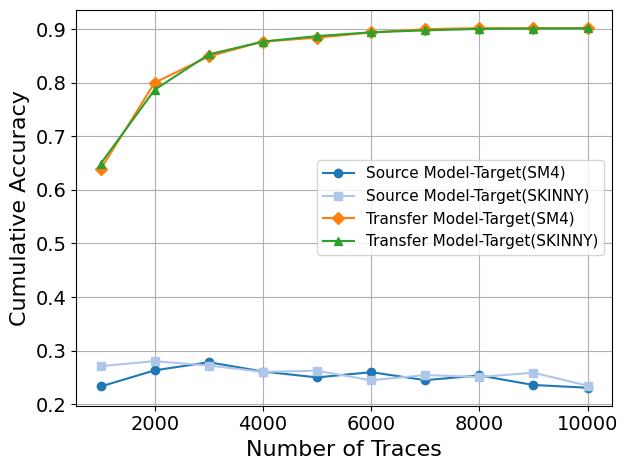

In [26]:
import matplotlib.pyplot as plt
from matplotlib import cm  # 用于颜色映射


colors = cm.get_cmap("tab20", 16)

# 定义不同的标记样式
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', '+', '>', '<', '8', 'H', '1', '2','3']

x=np.arange(1000,10001,1000)


plt.plot(x, SourceModel_SM4_ACC_avg, label='Source Model-Target(SM4)', marker=markers[0], markersize=6, color=colors(0))
plt.plot(x, SourceModel_Skinny_ACC_avg, label='Source Model-Target(SKINNY)', marker=markers[1], markersize=6, color=colors(1))
plt.plot(x, TransferModel_SM4_ACC_avg, label='Transfer Model-Target(SM4)', marker=markers[2], markersize=6, color=colors(2))
plt.plot(x, TransferModel_Skinny_ACC_avg, label='Transfer Model-Target(SKINNY)', marker=markers[3], markersize=6, color=colors(3))


plt.grid(True)
plt.xlabel('Number of Traces', fontsize=16)
plt.ylabel('Cumulative Accuracy', fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=11)


plt.tight_layout()  # 自动调整布局以避免重叠
plt.savefig('CA_AC_copies.pdf')


plt.show()
